# Experiment 1: All metrics / Default parameters / Synthetic data

## Setup

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os

from tqdm import tqdm
from tqdm.notebook import tqdm_notebook
tqdm_notebook.pandas()

In [2]:
project_root_path = os.path.join('..', '..')
experiment_path = os.path.join(project_root_path, 'experiments', 'allmetrics_defparams_syn')
results_path = os.path.join(experiment_path, 'results')

save_fig_path = os.path.join(experiment_path, 'figures')
os.makedirs(save_fig_path, exist_ok=True)

In [3]:
def load_results(csv_file):
    return pd.read_csv(csv_file, index_col=0)

result_files = [file for file in os.listdir(results_path) if file.endswith('.csv')]
print(f'Number of result files: {len(result_files)}')

Number of result files: 715


In [59]:
formal_names = {
    'FF-VUS-PR': 'FF-VUS (L: 128)',
    'FF-VUS-PR-GPU': 'FF-VUS-GPU (L: 128)',
    'AUC-PR': 'AUC',
    'VUS-PR': 'VUS (L: 128)',
    'RF': 'RF',
    'AFFILIATION': 'AFFILIATION',
    'RANGE-AUC-PR': 'Range-AUC (L: 128)',
}

color_palette = {
    'FF-VUS (L: 128)': '#eee13f',          # Good
    'FF-VUS-GPU (L: 128)': '#40da70',     # Very Good
    'AUC': '#f1a73f',                # Secondary competitor
    'VUS (L: 128)': '#b02a41',            # Main competitor
    'AFFILIATION': '#A5D1C2',        # Useless competitors
    'Range-AUC (L: 128)': '#547C6E',       # Useless competitors
    'RF': '#123327',                    # Useless competitors
}

In [60]:
# Initialize an empty DataFrame to store the combined data
df = pd.DataFrame()

# Read and combine all files
for file in tqdm(result_files):
    file_path = os.path.join(results_path, file)
    curr_df = pd.read_csv(file_path, index_col=0)
    df = pd.concat([df, curr_df], ignore_index=True)

df['Metric'] = df['Metric'].map(formal_names)
df.sample(3)

100%|████████████████████████████████████████| 715/715 [00:02<00:00, 250.82it/s]


,Time series,Length,Number of anomalies,Anomalies average length,Slope size,Step,Global mask,Slopes,Existence,Confusion matrix,...,Position time,Slopes time,Existence time,Confusion matrix time,Precision recall curve time,Integral time,Metric,Metric value,Metric time,Anomaly Coordinates time
2397,syn_1000_5_1_6.npy,1000,5,1.0,128.0,NaN,NaN,NaN,True,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,VUS (L: 128),1.000000,0.171465,NaN
4318,syn_10000_5_1_0.npy,10000,5,1.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,AFFILIATION,1.000000,0.003093,NaN
3855,syn_100000000_5_1000_0.npy,100000000,5,1205.4,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,AFFILIATION,0.995119,29.085316,NaN


## Analysis

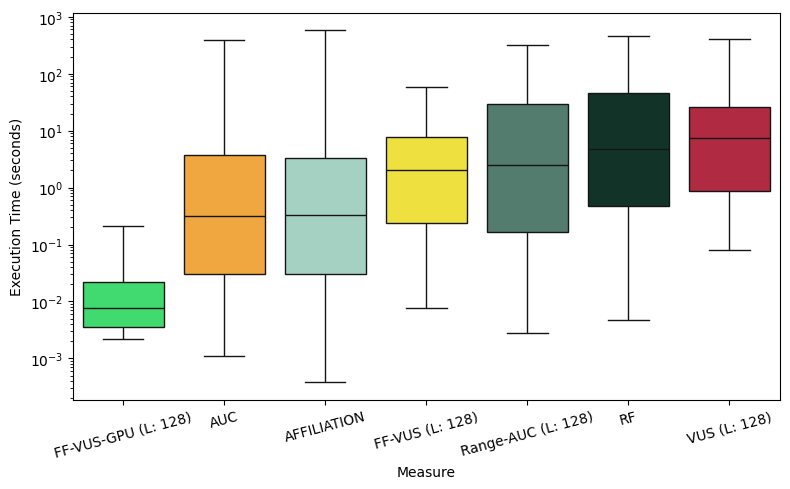

In [61]:
# TODO: Find why there is this big lines per metric, what affects this

# What is the execution time difference
median_times = df.groupby('Metric')['Metric time'].median()
order = median_times.sort_values().index.to_list()

plt.figure(figsize=(8, 5))
sns.boxplot(
    y='Metric time', 
    x='Metric', 
    hue='Metric', 
    data=df, 
    showfliers=False, 
    log_scale=True, 
    palette=color_palette, 
    order=order, 
    saturation=1,
    # showmeans=True, 
    # meanline=True
)
plt.xlabel('Measure')
plt.ylabel('Execution Time (seconds)')
plt.xticks(rotation=15)
plt.tight_layout()
plt.savefig(os.path.join(save_fig_path, 'exec_time_comparison.svg'))
plt.show()

Total number of time series: 1122
Total number of points: 29749380000, 29749380k, 29749m, 29b
Length min: 1000, max: 1000000000
Number of anomalies min: 1, max: 9006
Anomalies average length min: 1.0, max: 13642.5


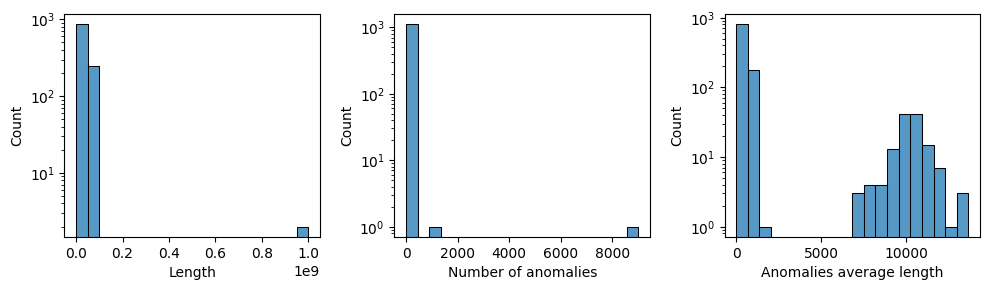

In [62]:
# Synthetic dataset insights
curr_df = df[df['Metric'] == 'AUC']
print(f"Total number of time series: {curr_df.shape[0]}")
print(f"Total number of points: {curr_df['Length'].sum()}, {curr_df['Length'].sum()//10**3}k, {curr_df['Length'].sum()//10**6}m, {curr_df['Length'].sum()//10**9}b")\

attributes = ["Length", "Number of anomalies", "Anomalies average length"]
attr_control = {}
fig, ax = plt.subplots(1, 3, figsize=(10, 3))
bins = 20
for attr, axis in zip(attributes, ax):
    print(f"{attr} min: {curr_df[attr].min()}, max: {curr_df[attr].max()}")
    fig = sns.histplot(x=attr, data=curr_df, ax=axis, bins=bins)
    axis.set_yscale('log')
    axis.set_xlabel(attr)
plt.tight_layout()
plt.show()

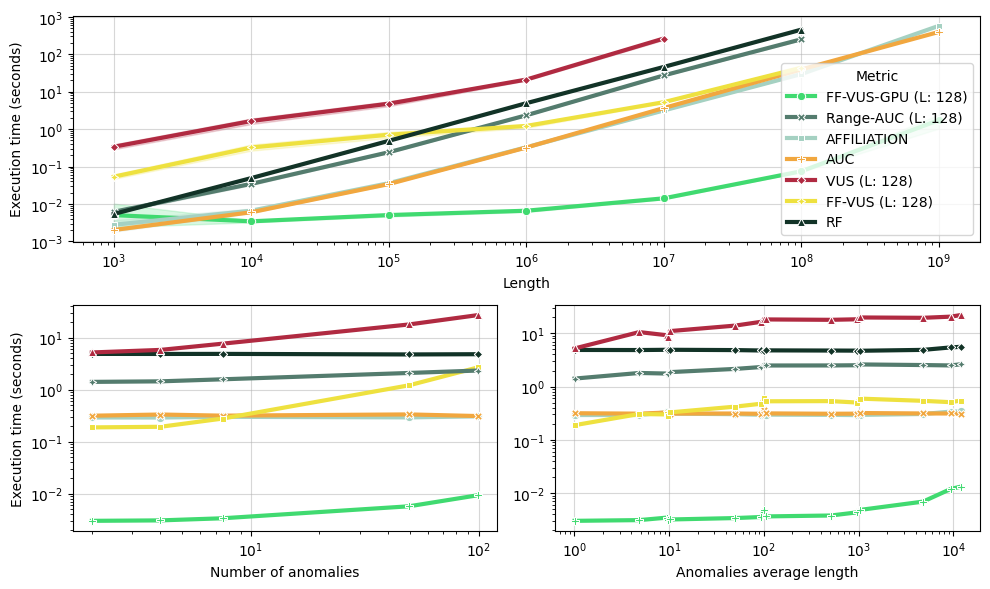

In [79]:
bins = 20
attr_control = {}
attributes = ["Length", "Number of anomalies", "Anomalies average length"]
for attr in attributes:
    df[f'{attr} bin'] = pd.qcut(df[attr], q=bins, duplicates='drop')
    attr_control[attr] = df[f'{attr} bin'].value_counts().idxmax()

attr_axis = {
    "Length": (2, 1, 1), 
    "Number of anomalies": (2, 2, 3), 
    "Anomalies average length": (2, 2, 4)
}
fig = plt.figure(figsize=(10, 6))
for i, attribute in enumerate(attributes):
    axis = fig.add_subplot(*attr_axis[attribute])

    mask = pd.Series(True, index=df.index)
    if attribute != 'Length':
        for attr in attributes:
            if attr != attribute:
                mask &= (df[f'{attr} bin'] == attr_control[attr])
    curr_df = df[mask]
    
    # Group by bin and metric, compute mean
    grouped = (
        curr_df
        .groupby([f'{attribute} bin', 'Metric'], observed=False)['Metric time']
        .mean()
        .reset_index()
    )
  
    # Convert bin to the midpoint for plotting
    grouped['bin_center'] = grouped[f'{attribute} bin'].apply(lambda x: x.mid)

    # Plot
    sns.lineplot(
        x='bin_center' if attribute != 'Length' else 'Length',
        y='Metric time',
        hue='Metric',
        data=grouped if attribute != 'Length' else curr_df,
        ax=axis,
        palette=color_palette,
        markers=True,
        style='Metric',
        dashes = False,
        linewidth=3,
        # size='Metric', 
        # size_order=['FF-VUS-GPU (L: 128)', 'FF-VUS (L: 128)', 'AFFILIATION', 'VUS (L: 128)', 'Range-AUC (L: 128)', 'RF', 'AUC']
    )

    axis.set_xlabel(attribute)
    axis.set_ylabel("Execution time (seconds)" if i != 2 else "")
    axis.set_yscale('log')
    axis.set_xscale('log')
    axis.grid(axis='both', alpha=0.5)
    if i != 0: 
        axis.get_legend().remove()

plt.tight_layout()
plt.savefig(os.path.join(save_fig_path, 'exec_time_per_attr.svg'))
plt.show()

In [75]:
df['Metric'].unique()

['FF-VUS-GPU (L: 128)', 'FF-VUS (L: 128)', 'VUS (L: 128)', 'AUC', 'Range-AUC (L: 128)', 'RF', 'AFFILIATION']

['FF-VUS-GPU (L: 128)',
 'FF-VUS (L: 128)',
 'VUS (L: 128)',
 'AUC',
 'Range-AUC (L: 128)',
 'RF',
 'AFFILIATION']